<a href="https://colab.research.google.com/github/andysegura/duck_classification_cr2g/blob/main/followupExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
from sklearn import utils
from sklearn.model_selection import train_test_split
from tensorflow import keras
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import os
import distutils

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Helper Functions

In [ ]:
def fuzzy(output, a, B, experiment):
  if experiment == 1:
    return output
  elif experiment == 2:
    if (output <= a):
      return 0
    if (output >= B):
      return 1
    return ((1/(B-a))*output)-(a/(B-a))
  else:
    if (output < 0.5):
      return 0
    else:
      return 1

In [ ]:
def create_dataset(body_part, attribute, x_filepaths, y_filepaths):
  #create x
  x = []
  for filepath in x_filepaths:
    x.append(np.load(filepath))
  x = tuple(x)
  X = np.vstack(x)
  X = X/np.amax(X)
  print(body_part, 'X shape: ', X.shape)
  
  #create y
  y = []
  for filepath in y_filepaths:
    y.append(np.load(filepath))
  y = tuple(y)
  Y = np.hstack(y)
  print(Y.shape)
  print(np.amax(Y))
  Y = tf.keras.utils.to_categorical(Y, num_classes = 2)
  print(attribute, "Y: ", Y.shape)
  X_validate, X, Y_validate, Y = train_test_split(X, Y, test_size = 0.95, random_state=42)
  X, Y = utils.shuffle(X, Y)
  print("Shuffled X shape: ", X.shape, " Shuffled Y shape: ", Y.shape)
  print("X_validate shape: ", X_validate.shape, "y_validate shape: ", Y_validate.shape)
  return X, Y, X_validate, Y_validate

In [ ]:
def default_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (4,4), input_shape = (200, 200, 3)))
  model.add(tf.keras.layers.SpatialDropout2D(0.2))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(300))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(2, activation="softmax"))
  return model

# Experiments

## Baseline: Images as-is with no splitting of body parts

In [ ]:
XD = np.load('/content/drive/MyDrive/Data/fuzzy/diazi_X_200.npy')
XP = np.load('/content/drive/MyDrive/Data/fuzzy/platy_X_200.npy')
print("XD shape: ", XD.shape)
print("XP shape: ", XP.shape)
YD = np.zeros(XD.shape[0])
YP = np.zeros(XP.shape[0]) + 1
print("YD shape: ", YD.shape)
print("YP shape: ", YP.shape)
X = np.vstack((XD, XP))
Y = np.hstack((YD, YP))
print("Final X shape: ", X.shape)
print("Final Y shape: ", Y.shape)

XD shape:  (3996, 200, 200, 3)
XP shape:  (1404, 200, 200, 3)
YD shape:  (3996,)
YP shape:  (1404,)
Final X shape:  (5400, 200, 200, 3)
Final Y shape:  (5400,)


(200, 200, 3)


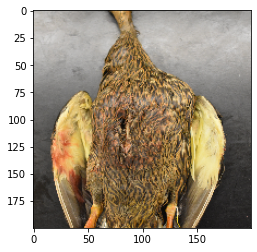

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig,ax = plt.subplots()

image = cv2.cvtColor(XD[500], cv2.COLOR_BGR2RGB)
pixels = np.array(image)
plt.imshow(pixels)
print(pixels.shape)

In [ ]:
X, Y = utils.shuffle(X, Y)
print("Shuffled X shape: ", X.shape, " Shuffled Y shape: ", Y.shape)
Y = tf.keras.utils.to_categorical(Y, num_classes=2)
print("one hot Y shape: ", Y.shape)
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_validate, y_validate, test_size = 0.90, random_state=42)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_validation shape: ", X_validate.shape)
print("Y_validation shape: ", y_validate.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", y_test.shape)

Shuffled X shape:  (5400, 200, 200, 3)  Shuffled Y shape:  (5400,)
one hot Y shape:  (5400, 2)
X_train shape:  (3780, 200, 200, 3)
Y_train shape:  (3780, 2)
X_validation shape:  (1458, 200, 200, 3)
Y_validation shape:  (1458, 2)
X_test shape:  (162, 200, 200, 3)
Y_test shape:  (162, 2)


In [ ]:
def baseline_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(4, (4,4), input_shape = (200, 200, 3)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(2, activation="softmax"))
  return model

In [ ]:
model = baseline_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 197, 197, 4)       196       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 98, 98, 4)        0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 38416)             0         
                                                                 
 dense_28 (Dense)            (None, 100)               3841700   
                                                                 
 activation_14 (Activation)  (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 2)                 202       
                                                     

Epoch 1/10
60/60 [==============================] - 2s 32ms/step - loss: 423.2127 - accuracy: 0.8354 - val_loss: 18.8065 - val_accuracy: 0.9280
Epoch 2/10
60/60 [==============================] - 1s 24ms/step - loss: 6.8504 - accuracy: 0.9389 - val_loss: 3.9376 - val_accuracy: 0.9396
Epoch 3/10
60/60 [==============================] - 1s 24ms/step - loss: 1.4610 - accuracy: 0.9680 - val_loss: 2.9724 - val_accuracy: 0.9609
Epoch 4/10
60/60 [==============================] - 1s 24ms/step - loss: 1.1328 - accuracy: 0.9735 - val_loss: 2.6072 - val_accuracy: 0.9650
Epoch 5/10
60/60 [==============================] - 1s 24ms/step - loss: 1.6637 - accuracy: 0.9683 - val_loss: 3.4978 - val_accuracy: 0.9630
Epoch 6/10
60/60 [==============================] - 1s 24ms/step - loss: 0.4822 - accuracy: 0.9839 - val_loss: 6.3067 - val_accuracy: 0.9417
Epoch 7/10
60/60 [==============================] - 1s 22ms/step - loss: 0.5326 - accuracy: 0.9870 - val_loss: 4.8244 - val_accuracy: 0.9595
Epoch 8/10

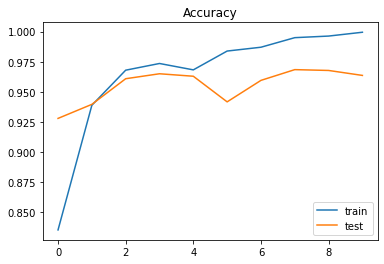

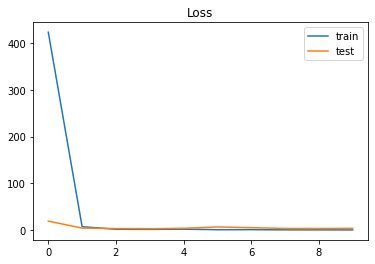

In [ ]:
batch_size = 64
epochs = 10

history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    initial_epoch=len(loss),
    epochs=epochs + len(loss),
    validation_data=(X_validate.astype(np.float32), y_validate.astype(np.float32)),
    batch_size=batch_size,
    verbose=1,
)

loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.7833847403526306
Test accuracy: 97 %


## Experiment 1: Feeding data based on body part

### Head

#### Face & Neck

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_HEAD_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_HEAD_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_FACE_NECK_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_FACE_NECK_200.npy']
X, Y, x_validate, y_validate = create_dataset('Head', 'Face & Neck', x_filepaths, y_filepaths)

Head X shape:  (2328, 200, 200, 3)
(2328,)
1
Face & Neck Y:  (2328, 2)
Shuffled X shape:  (2212, 200, 200, 3)  Shuffled Y shape:  (2212, 2)
X_validate shape:  (116, 200, 200, 3) y_validate shape:  (116, 2)


In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 307328)            0         
                                                                 
 dense_2 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_1 (Dropout)         (None, 300)              

K fold: 1
Shape of X_train, y_train:  1474 1474
Shape of X_test, y_test:  738 738
Epoch 1/20
24/24 [==============================] - 2s 76ms/step - loss: 14.4978 - accuracy: 0.7144 - val_loss: 0.4402 - val_accuracy: 0.8266
Epoch 2/20
24/24 [==============================] - 2s 65ms/step - loss: 0.6491 - accuracy: 0.7802 - val_loss: 0.3003 - val_accuracy: 0.8306
Epoch 3/20
24/24 [==============================] - 2s 66ms/step - loss: 0.3655 - accuracy: 0.8046 - val_loss: 0.2800 - val_accuracy: 0.8320
Epoch 4/20
24/24 [==============================] - 2s 66ms/step - loss: 0.3130 - accuracy: 0.8107 - val_loss: 0.2316 - val_accuracy: 0.8604
Epoch 5/20
24/24 [==============================] - 2s 66ms/step - loss: 0.2895 - accuracy: 0.8630 - val_loss: 0.2183 - val_accuracy: 0.8835
Epoch 6/20
24/24 [==============================] - 2s 66ms/step - loss: 0.2645 - accuracy: 0.8860 - val_loss: 0.2690 - val_accuracy: 0.8767
Epoch 7/20
24/24 [==============================] - 2s 65ms/step - loss

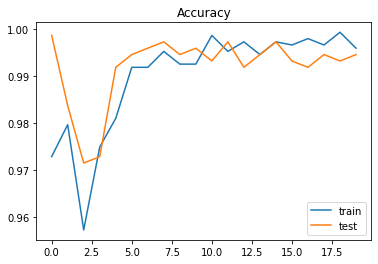

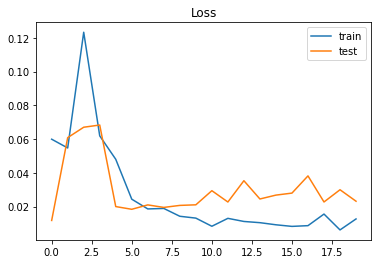

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.36968371272087097
Test accuracy: 94 %


### Wing

#### Primary Covert Pattern

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_WING_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_WING_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_PRIMARY_COVERT_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_PRIMARY_COVERT_200.npy']
X, Y, x_validate, y_validate = create_dataset('Wing', 'Primary Covert Pattern', x_filepaths, y_filepaths)

Wing X shape:  (2520, 200, 200, 3)
(2520,)
1
Primary Covert Pattern Y:  (2520, 2)
Shuffled X shape:  (2394, 200, 200, 3)  Shuffled Y shape:  (2394, 2)
X_validate shape:  (126, 200, 200, 3) y_validate shape:  (126, 2)


In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 307328)            0         
                                                                 
 dense_4 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_2 (Dropout)         (None, 300)              

K fold: 1
Shape of X_train, y_train:  1596 1596
Shape of X_test, y_test:  798 798
Epoch 1/20
25/25 [==============================] - 3s 83ms/step - loss: 9.4165 - accuracy: 0.6203 - val_loss: 0.5259 - val_accuracy: 0.7769
Epoch 2/20
25/25 [==============================] - 2s 67ms/step - loss: 0.4298 - accuracy: 0.8390 - val_loss: 0.3415 - val_accuracy: 0.8747
Epoch 3/20
25/25 [==============================] - 2s 67ms/step - loss: 0.2905 - accuracy: 0.8954 - val_loss: 0.3062 - val_accuracy: 0.8847
Epoch 4/20
25/25 [==============================] - 2s 68ms/step - loss: 0.2421 - accuracy: 0.9135 - val_loss: 0.3095 - val_accuracy: 0.8734
Epoch 5/20
25/25 [==============================] - 2s 67ms/step - loss: 0.2035 - accuracy: 0.9267 - val_loss: 0.2904 - val_accuracy: 0.8922
Epoch 6/20
25/25 [==============================] - 2s 68ms/step - loss: 0.1646 - accuracy: 0.9405 - val_loss: 0.2913 - val_accuracy: 0.8997
Epoch 7/20
25/25 [==============================] - 2s 69ms/step - loss:

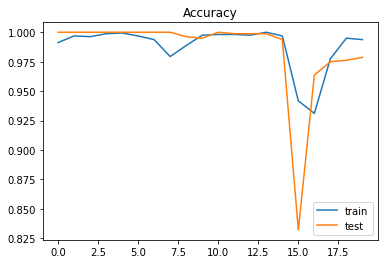

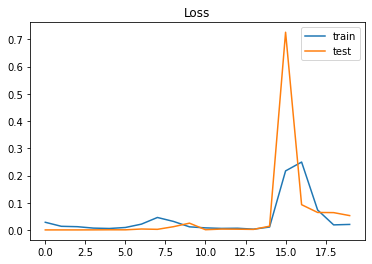

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.36879268288612366
Test accuracy: 91 %


#### Lesser Covert Pattern

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_WING_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_WING_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_LESSER_COVERT_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_LESSER_COVERT_200.npy']
X, Y, x_validate, y_validate = create_dataset('Wing', 'Lesser Covert Pattern', x_filepaths, y_filepaths)

Wing X shape:  (2520, 200, 200, 3)
(2520,)
1
Lesser Covert Pattern Y:  (2520, 2)
Shuffled X shape:  (2394, 200, 200, 3)  Shuffled Y shape:  (2394, 2)
X_validate shape:  (126, 200, 200, 3) y_validate shape:  (126, 2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 198, 198, 64)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 627264)            0         
                                                                 
 dense_6 (Dense)             (None, 100)               62726500  
                                                                 
 dropout_3 (Dropout)         (None, 100)              

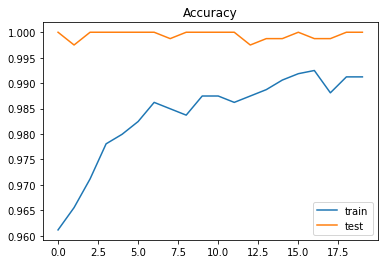

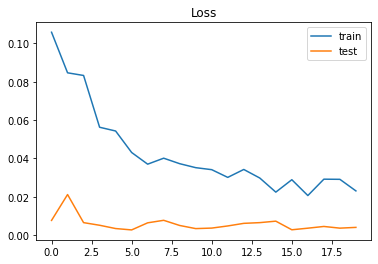

In [ ]:
def lesser_covert_pattern_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape = (200, 200, 3)))
  model.add(tf.keras.layers.SpatialDropout2D(0.1))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(2, activation="softmax"))
  return model
model = lesser_covert_pattern_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.6375661492347717
Test accuracy: 79 %


#### Greater Secondary Coverts Pattern

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_WING_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_WING_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_GREATER_SECONDARY_COVERT_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_GREATER_SECONDARY_COVERT_200.npy']
X, Y, x_validate, y_validate = create_dataset('Wing', 'Secondary Covert Pattern', x_filepaths, y_filepaths)

Wing X shape:  (2520, 200, 200, 3)
(2520,)
1
Secondary Covert Pattern Y:  (2520, 2)
Shuffled X shape:  (2394, 200, 200, 3)  Shuffled Y shape:  (2394, 2)
X_validate shape:  (126, 200, 200, 3) y_validate shape:  (126, 2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d (SpatialD  (None, 197, 197, 32)     0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 307328)            0         
                                                                 
 dense (Dense)               (None, 300)               92198700  
                                                                 
 dropout (Dropout)           (None, 300)               0

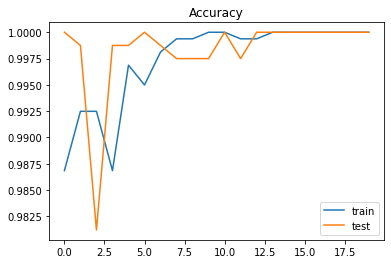

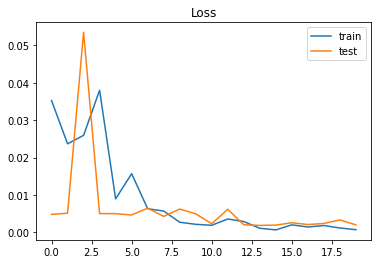

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.35784420371055603
Test accuracy: 94 %


#### Speculum

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_WING_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_WING_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_SPECULUM_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_SPECULUM_200.npy']
X, Y, x_validate, y_validate = create_dataset('Wing', 'Speculum', x_filepaths, y_filepaths)

Wing X shape:  (2520, 200, 200, 3)
(2520,)
1
Speculum Y:  (2520, 2)
Shuffled X shape:  (2394, 200, 200, 3)  Shuffled Y shape:  (2394, 2)
X_validate shape:  (126, 200, 200, 3) y_validate shape:  (126, 2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 307328)            0         
                                                                 
 dense_2 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_1 (Dropout)         (None, 300)              

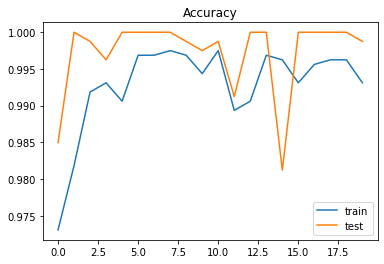

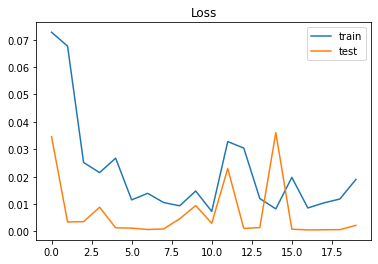

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.09079951047897339
Test accuracy: 98 %


### Body Dorsal

##### Rump

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_BODY_DORSAL_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_BODY_DORSAL_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_RUMP_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_RUMP_200.npy']
X, Y, x_validate, y_validate = create_dataset('Body Dorsal', 'Rump', x_filepaths, y_filepaths)

Body Dorsal X shape:  (4344, 200, 200, 3)
(4344,)
1
Rump Y:  (4344, 2)
Shuffled X shape:  (4127, 200, 200, 3)  Shuffled Y shape:  (4127, 2)
X_validate shape:  (217, 200, 200, 3) y_validate shape:  (217, 2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 307328)            0         
                                                                 
 dense_4 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_2 (Dropout)         (None, 300)              

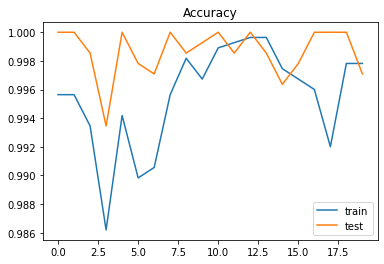

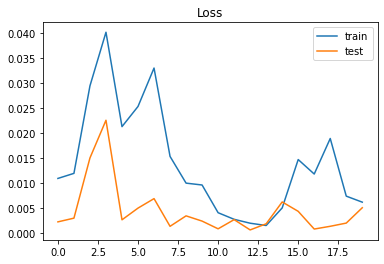

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.018835239112377167
Test accuracy: 100 %


#### Scapular

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_BODY_DORSAL_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_BODY_DORSAL_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_SCAPULAR_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_SCAPULAR_200.npy']
X, Y, x_validate, y_validate = create_dataset('Body Dorsal', 'Scapular', x_filepaths, y_filepaths)

Body Dorsal X shape:  (4344, 200, 200, 3)
(4344,)
1
Scapular Y:  (4344, 2)
Shuffled X shape:  (4127, 200, 200, 3)  Shuffled Y shape:  (4127, 2)
X_validate shape:  (217, 200, 200, 3) y_validate shape:  (217, 2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d (SpatialD  (None, 197, 197, 32)     0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 307328)            0         
                                                                 
 dense (Dense)               (None, 300)               92198700  
                                                                 
 dropout (Dropout)           (None, 300)               0

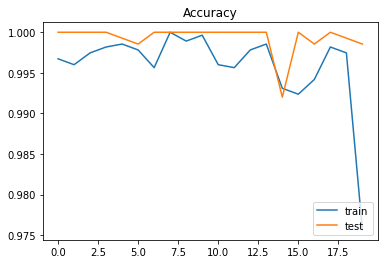

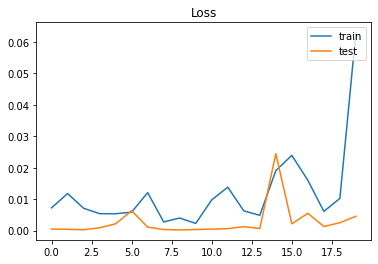

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.05677633360028267
Test accuracy: 99 %


#### Outer 2 Tail Feathers

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_BODY_DORSAL_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_BODY_DORSAL_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_OUTER_FEATHERS_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_OUTER_FEATHERS_200.npy']
X, Y, x_validate, y_validate = create_dataset('Body Dorsal', 'Scapular', x_filepaths, y_filepaths)

Body Dorsal X shape:  (4344, 200, 200, 3)
(4344,)
1
Scapular Y:  (4344, 2)
Shuffled X shape:  (4127, 200, 200, 3)  Shuffled Y shape:  (4127, 2)
X_validate shape:  (217, 200, 200, 3) y_validate shape:  (217, 2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 307328)            0         
                                                                 
 dense_6 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_3 (Dropout)         (None, 300)              

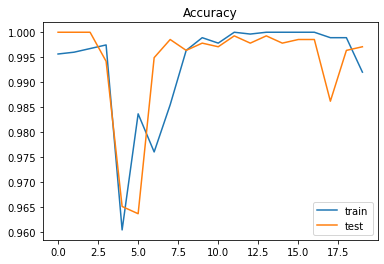

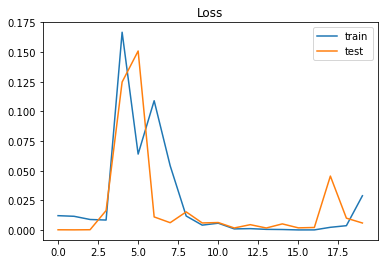

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.008399010635912418
Test accuracy: 100 %


### Body Ventral

#### Breast Belly

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_BODY_VENTRAL_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_BODY_VENTRAL_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_BREAST_BELLY_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_BREAST_BELLY_200.npy']
X, Y, x_validate, y_validate = create_dataset('Body Dorsal', 'Scapular', x_filepaths, y_filepaths)

Body Dorsal X shape:  (3864, 200, 200, 3)
(3864,)
1
Scapular Y:  (3864, 2)
Shuffled X shape:  (3671, 200, 200, 3)  Shuffled Y shape:  (3671, 2)
X_validate shape:  (193, 200, 200, 3) y_validate shape:  (193, 2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 307328)            0         
                                                                 
 dense_2 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_1 (Dropout)         (None, 300)              

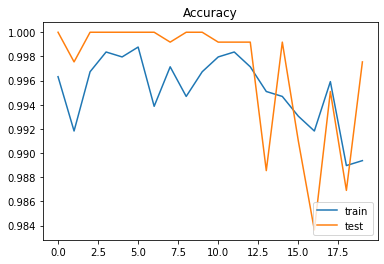

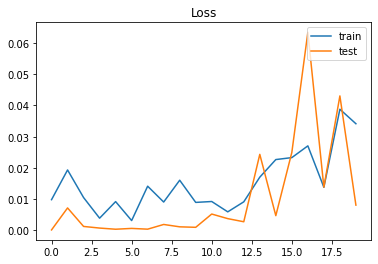

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.32083162665367126
Test accuracy: 97 %


#### Overall Breast Belly

In [ ]:
x_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_X_BODY_VENTRAL_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_X_BODY_VENTRAL_200.npy']
y_filepaths = ['/content/drive/MyDrive/Data/fuzzy/diazi_Y_OVERALL_BREAST_BELLY_200.npy', '/content/drive/MyDrive/Data/fuzzy/platy_Y_OVERALL_BREAST_BELLY_200.npy']
X, Y, x_validate, y_validate = create_dataset('Body Ventral', 'Overall Breast Belly', x_filepaths, y_filepaths)

Body Ventral X shape:  (3864, 200, 200, 3)
(3864,)
1
Overall Breast Belly Y:  (3864, 2)
Shuffled X shape:  (3671, 200, 200, 3)  Shuffled Y shape:  (3671, 2)
X_validate shape:  (193, 200, 200, 3) y_validate shape:  (193, 2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 197, 197, 32)      1568      
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 197, 197, 32)     0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 307328)            0         
                                                                 
 dense_4 (Dense)             (None, 300)               92198700  
                                                                 
 dropout_2 (Dropout)         (None, 300)              

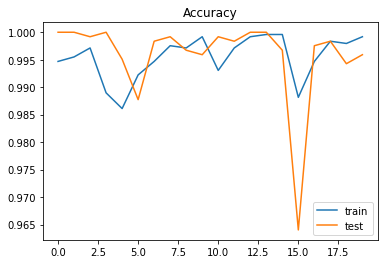

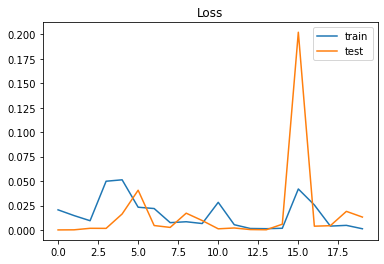

In [ ]:
model = default_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
folds = 1

for train_index, test_index in kf.split(X):
  print("K fold:", folds)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  print("Shape of X_train, y_train: ", len(X_train), len(y_train))
  print("Shape of X_test, y_test: ", len(X_test), len(y_test))

  batch_size = 64
  epochs = 20
  history = model.fit(
      X_train.astype(np.float32), y_train.astype(np.float32),
      initial_epoch=len(loss),
      epochs=epochs + len(loss),
      validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
      batch_size=batch_size,
      verbose=1,
  )

  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  folds += 1

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

In [ ]:
score = model.evaluate(x_validate, y_validate, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', round(score[1]*100), "%")

Test loss: 0.10870752483606339
Test accuracy: 99 %


## Experiment 2: Tuples




In [ ]:
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    initial_epoch=len(loss),
    epochs=epochs + len(loss),
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    batch_size=batch_size,
    verbose=1,
)

loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

Epoch 121/130
47/47 [==============================] - 2s 37ms/step - loss: 0.0625 - accuracy: 0.9769 - val_loss: 0.0171 - val_accuracy: 0.9946
Epoch 122/130
47/47 [==============================] - 1s 28ms/step - loss: 0.0657 - accuracy: 0.9797 - val_loss: 0.0377 - val_accuracy: 0.9851
Epoch 123/130
47/47 [==============================] - 1s 28ms/step - loss: 0.2897 - accuracy: 0.9478 - val_loss: 0.1483 - val_accuracy: 0.9498
Epoch 124/130
47/47 [==============================] - 1s 28ms/step - loss: 0.0788 - accuracy: 0.9654 - val_loss: 0.1314 - val_accuracy: 0.9769
Epoch 125/130
31/47 [==================>...........] - ETA: 0s - loss: 0.0746 - accuracy: 0.9859

KeyboardInterrupt: ignored

## Experiment 3: α = $\frac{1}{3}$ β = $\frac{2}{3}$

In [ ]:
XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
print("XD shape: ", XD.shape)
print("XP shape: ", XP.shape)
YD = np.zeros(XD.shape[0])
YP = np.zeros(XP.shape[0]) + 1
print("YD shape: ", YD.shape)
print("YP shape: ", YP.shape)
X = np.vstack((XD, XP))
Y = np.hstack((YD, YP))
Y = tf.keras.utils.to_categorical(Y, num_classes=2)
print("Final X shape: ", X.shape)
print("Final Y shape: ", Y.shape)

XD shape:  (2148, 9)
XP shape:  (2208, 9)
YD shape:  (2148,)
YP shape:  (2208,)
Final X shape:  (4356, 9)
Final Y shape:  (4356, 2)


In [ ]:
print(X[0])

[1.3855400e-07 1.7182957e-02 6.1936979e-04 1.5705766e-04 1.8984964e-01
 1.2081553e-04 1.1429278e-01 1.1989998e-02 1.4719006e-01]


In [ ]:
for row in range(X.shape[0]):
  for column in range(X.shape[1]):
    X[row][column] = fuzzy(X[row][column], (1/3), (2/3), 2)

In [ ]:
print(X[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
X, Y = utils.shuffle(X, Y)
print("Shuffled X shape: ", X.shape, " Shuffled Y shape: ", Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)

Shuffled X shape:  (4356, 9)  Shuffled Y shape:  (4356, 2)
X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)


In [ ]:
def model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(32, input_shape = (9,), activation = 'relu'))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  return model

In [ ]:
model = model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Epoch 1/10
24/24 [==============================] - 1s 9ms/step - loss: 0.5541 - accuracy: 0.7386 - val_loss: 0.4578 - val_accuracy: 0.7728
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4107 - accuracy: 0.8196 - val_loss: 0.3519 - val_accuracy: 0.9044
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.9813 - val_loss: 0.2717 - val_accuracy: 0.9939
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.2454 - accuracy: 0.9977 - val_loss: 0.2066 - val_accuracy: 0.9969
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1861 - accuracy: 0.9970 - val_loss: 0.1559 - val_accuracy: 0.9969
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9980 - val_loss: 0.1190 - val_accuracy: 0.9969
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9977 - val_loss: 0.0918 - val_accuracy: 0.9977
Epoch 8/10
24/24 [==

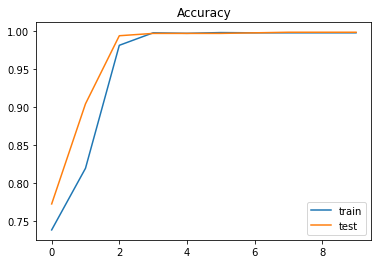

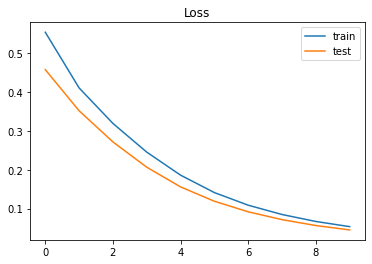

In [ ]:
batch_size = 128
epochs = 10

history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    initial_epoch=len(loss),
    epochs=epochs + len(loss),
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    batch_size=batch_size,
    verbose=1,
)

loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

## Experiment 4: 0 if $\leq$ 0.5, 1 > 0.5

In [ ]:
XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
print("XD shape: ", XD.shape)
print("XP shape: ", XP.shape)
YD = np.zeros(XD.shape[0])
YP = np.zeros(XP.shape[0]) + 1
print("YD shape: ", YD.shape)
print("YP shape: ", YP.shape)
X = np.vstack((XD, XP))
Y = np.hstack((YD, YP))
Y = tf.keras.utils.to_categorical(Y, num_classes=2)
print("one hot Y shape: ", Y.shape)
print("Final X shape: ", X.shape)
print("Final Y shape: ", Y.shape)

XD shape:  (2148, 9)
XP shape:  (2208, 9)
YD shape:  (2148,)
YP shape:  (2208,)
one hot Y shape:  (4356, 2)
Final X shape:  (4356, 9)
Final Y shape:  (4356, 2)


In [ ]:
print(X[0])

[1.3855400e-07 1.7182957e-02 6.1936979e-04 1.5705766e-04 1.8984964e-01
 1.2081553e-04 1.1429278e-01 1.1989998e-02 1.4719006e-01]


In [ ]:
for row in range(X.shape[0]):
  for column in range(X.shape[1]):
    X[row][column] = fuzzy(X[row][column], 0, 0, 3)

In [ ]:
print(X[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
X, Y = utils.shuffle(X, Y)
print("Shuffled X shape: ", X.shape, " Shuffled Y shape: ", Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)

Shuffled X shape:  (4356, 9)  Shuffled Y shape:  (4356, 2)
X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)


In [ ]:
def model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(32, input_shape = (9,), activation = 'relu'))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  return model

In [ ]:
model = model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                320       
                                                                 
 dense_6 (Dense)             (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Epoch 1/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5981 - accuracy: 0.6127 - val_loss: 0.4716 - val_accuracy: 0.9602
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4087 - accuracy: 0.9616 - val_loss: 0.3739 - val_accuracy: 0.9717
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 0.9705 - val_loss: 0.3036 - val_accuracy: 0.9725
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2636 - accuracy: 0.9813 - val_loss: 0.2431 - val_accuracy: 0.9954
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.2106 - accuracy: 0.9957 - val_loss: 0.1929 - val_accuracy: 0.9962
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1665 - accuracy: 0.9970 - val_loss: 0.1510 - val_accuracy: 0.9985
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.1311 - accuracy: 0.9984 - val_loss: 0.1180 - val_accuracy: 0.9985
Epoch 8/10
24/24 [==

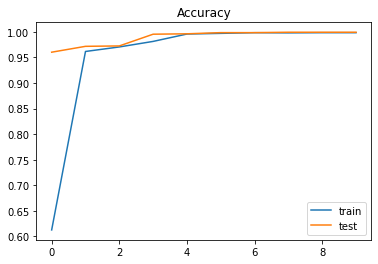

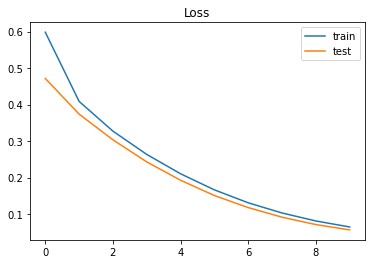

In [ ]:
batch_size = 128
epochs = 10

history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    initial_epoch=len(loss),
    epochs=epochs + len(loss),
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    batch_size=batch_size,
    verbose=1,
)

loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']

print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

## Experimenting with α and β

In [ ]:
def create_X():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  X = np.vstack((XD, XP))
  return X
def create_Y():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  YD = np.zeros(XD.shape[0])
  YP = np.zeros(XP.shape[0]) + 1
  Y = np.hstack((YD, YP))
  return Y

In [ ]:
parameters = {}
tuples = [(1/4, 3/4)]
for i in range(len(tuples)):
  parameters[i] = tuples[i]
print(parameters)

{0: (0.25, 0.75)}


In [ ]:
datasets = []
for i in range(len(parameters)):
  tempX = create_X()
  print('iteration: ', i)
  print(tempX[0])
  print('alpha = ', parameters[i][0])
  print('beta = ', parameters[i][1])
  for row in range(tempX.shape[0]):
    for column in range(tempX.shape[1]):
      tempX[row][column] = fuzzy(tempX[row][column], parameters[i][0], parameters[i][1], 2)
  print(tempX[0])
  datasets.append(tempX)

iteration:  0
[1.3855400e-07 1.7182957e-02 6.1936979e-04 1.5705766e-04 1.8984964e-01
 1.2081553e-04 1.1429278e-01 1.1989998e-02 1.4719006e-01]
alpha =  0.25
beta =  0.75
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
datasets = np.array(datasets)
print(datasets.shape)

(1, 4356, 9)


In [ ]:
def create_model():
  a = tf.keras.models.Sequential()
  a.add(tf.keras.layers.Dense(32, input_shape = (9,), activation = 'relu'))
  a.add(tf.keras.layers.Dropout(0.2))
  a.add(tf.keras.layers.Dense(2, activation='softmax'))
  return a

Shuffled X shape:  (4356, 9)  Shuffled Y shape:  (4356,)
one hot Y shape:  (4356, 2)
X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                320       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.4048 - accuracy: 0.9288 - val_loss: 0.2222 - val_accuracy: 

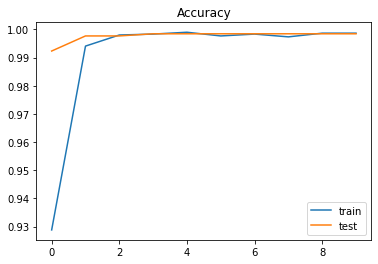

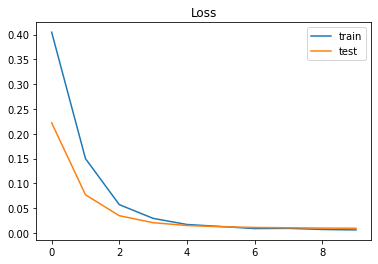

In [ ]:
Y = create_Y()
for item in datasets:
  model = None
  tempX = item
  tempY = Y
  tempX, tempY = utils.shuffle(tempX, tempY)
  print("Shuffled X shape: ", tempX.shape, " Shuffled Y shape: ", tempY.shape)
  tempY = tf.keras.utils.to_categorical(tempY, num_classes=2)
  print("one hot Y shape: ", tempY.shape)
  X_train, X_test, y_train, y_test = train_test_split(tempX, tempY, test_size=0.3, random_state=42)
  print("X_train shape: ", X_train.shape)
  print("X_test shape: ", X_test.shape)
  print("Y_train shape: ", y_train.shape)
  print("Y_test shape: ", y_test.shape)
  model = create_model()
  loss, val_loss, accuracy, val_accuracy = [], [], [], []
  model.summary()
  lr = 1e-2
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  batch_size = 32
  epochs = 10
  history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    initial_epoch=len(loss),
    epochs=epochs + len(loss),
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    batch_size=batch_size,
    verbose=1,
  )
  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
  print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
  print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
  print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
  fig, ax = plt.subplots()
  ax.plot(history.history['accuracy'],label = 'train')
  ax.plot(history.history['val_accuracy'],label = 'test')
  ax.set_title('Accuracy')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(history.history['loss'],label = 'train')
  ax.plot(history.history['val_loss'],label = 'test')
  ax.set_title('Loss')
  ax.legend(loc='upper right')

## Follow Up Experiments

In [ ]:
def create_X():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  X = np.vstack((XD, XP))
  return X
def create_Y():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  YD = np.zeros(XD.shape[0])
  YP = np.zeros(XP.shape[0]) + 1
  Y = np.hstack((YD, YP))
  return Y

In [ ]:
import random

In [ ]:
tempX = create_X()
tempY = create_Y()
tempY = tf.keras.utils.to_categorical(tempY, num_classes=2)
print(tempX.shape, tempY.shape)

(4356, 9) (4356, 2)


In [ ]:
random.uniform(.15, .2545)

0.25036418404508703

In [ ]:
import random

for i in range(tempX.shape[0]):
  indices = []
  for j in range(9):
    indices.append(random.randint(0, 8))
  for index in indices:
    d = random.uniform(.25, .45)
    if (tempX[0][index]) < 0.55:
      '''
      #if ((tempX[0][index]) + d)
      '''
      tempX[0][index] = tempX[0][index] + d
      '''
      else:
        tempX[0][index] = 0.55
    '''
    elif (tempX[0][index]) > 0.45:
      '''
      if ((tempX[0][index]) - d) > 0.45:
      '''
      tempX[0][index] = tempX[0][index] - d
      '''
      else:
        tempX[0][index] = 0.45
      '''
  

In [ ]:
print(tempX[1])

[5.2492796e-06 6.8709939e-03 3.6329338e-03 1.2543125e-04 2.6300627e-01
 3.1521202e-05 8.1195164e-01 2.2718259e-04 6.6409752e-02]


In [ ]:
print(tempX.shape)

(4356, 9)


In [ ]:
ex = np.zeros_like(tempX) + 1

In [ ]:
for row in range(ex.shape[0]):
  for column in range(ex.shape[1]):
    tempX[row][column] = fuzzy(ex[row][column], (1/4), (3/4), 2)
print(tempX[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(ex, tempY, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
35/35 [==============================] - 0s 2ms/step - loss: 4.0902 - accuracy: 0.5069
test loss, test acc: [4.090163230895996, 0.5068870782852173]


In [ ]:
def create_model():
  a = tf.keras.models.Sequential()
  a.add(tf.keras.layers.Dense(32, input_shape = (9,), activation = 'relu'))
  a.add(tf.keras.layers.Dense(2, activation='softmax'))
  return a

X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                320       
                                                                 
 dense_10 (Dense)            (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.6946 - accuracy: 0.4969 - val_loss: 0.6952 - val_accuracy: 0.4904
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5116 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 3/10
96/96 [==============================] - 0s 3ms/step - loss

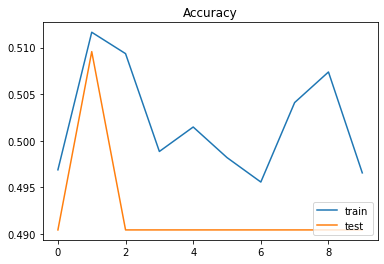

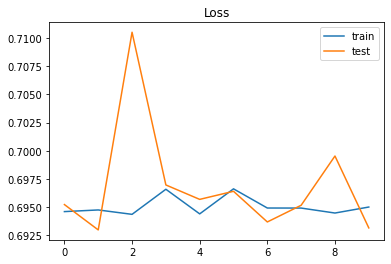

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tempX, tempY, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)
model = create_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
batch_size = 32
epochs = 10
history = model.fit(
X_train.astype(np.float32), y_train.astype(np.float32),
initial_epoch=len(loss),
epochs=epochs + len(loss),
validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
batch_size=batch_size,
verbose=1,
)
loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']
print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

## No Fuzzy, but Uncertainty

In [ ]:
def create_X():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  print("XD Shape: ", XD.shape)
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  print("XP Shape: ", XP.shape)
  X = np.vstack((XD, XP))
  return X
def create_Y():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  YD = np.zeros(XD.shape[0])
  YP = np.zeros(XP.shape[0]) + 1
  Y = np.hstack((YD, YP))
  return Y

In [ ]:
tempX = create_X()
tempY = create_Y()
tempY = tf.keras.utils.to_categorical(tempY, num_classes=2)
print(tempX.shape, tempY.shape)

XD Shape:  (2148, 9)
XP Shape:  (2208, 9)
(4356, 9) (4356, 2)


In [ ]:
print(tempX[0])

[1.3855400e-07 1.7182957e-02 6.1936979e-04 1.5705766e-04 1.8984964e-01
 1.2081553e-04 1.1429278e-01 1.1989998e-02 1.4719006e-01]


In [ ]:
import random

for i in range(tempX.shape[0]):
  indices = []
  for j in range(9):
    indices.append(random.randint(0, 8))
  for index in indices:
    d = random.uniform(.15, .25)
    if (tempX[0][index]) < 0.45:
      if ((tempX[0][index]) - d) >= 0:
        tempX[0][index] = tempX[0][index] - d
      elif ((tempX[0][index]) + d) < 0.45:
        tempX[0][index] = tempX[0][index] + d
      else:
        tempX[0][index] = 0
    elif (tempX[0][index]) > 0.55:
      if ((tempX[0][index]) + d) < 1:
        tempX[0][index] = tempX[0][index] + d
      if (tempX[0][index] - d) > 0.55:
          tempX[0][index] = tempX[0][index] - d
      else:
        tempX[0][index] = 1

In [ ]:
print(tempX[0])

[0.36734074 0.02537199 0.2499362  0.05160062 0.16167165 0.0063556
 0.30017644 0.3851637  0.01020234]


In [ ]:
def create_model():
  a = tf.keras.models.Sequential()
  a.add(tf.keras.layers.Dense(32, input_shape = (9,), activation = 'relu'))
  a.add(tf.keras.layers.Dropout(0.2))
  a.add(tf.keras.layers.Dense(2, activation='softmax'))
  return a

X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                320       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.3969 - accuracy: 0.8823 - val_loss: 0.2588 - val_accuracy: 0.9870
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.1523

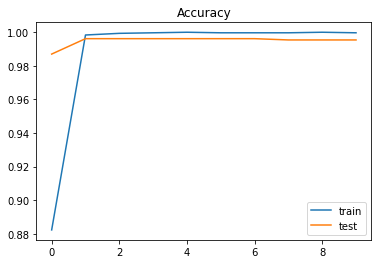

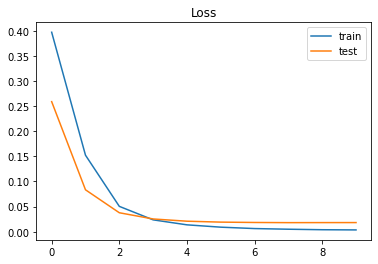

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tempX, tempY, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)
model = create_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
batch_size = 32
epochs = 10
history = model.fit(
X_train.astype(np.float32), y_train.astype(np.float32),
initial_epoch=len(loss),
epochs=epochs + len(loss),
validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
batch_size=batch_size,
verbose=1,
)
loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']
print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')

stuff stuff stuff

In [ ]:
def create_X():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  print("XD Shape: ", XD.shape)
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  print("XP Shape: ", XP.shape)
  X = np.vstack((XD, XP))
  return X
def create_Y():
  XD = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_diazi.npy')
  XP = np.load('/content/drive/MyDrive/Data/fuzzy/attribute_predictions_platy.npy')
  YD = np.zeros(XD.shape[0])
  YP = np.zeros(XP.shape[0]) + 1
  Y = np.hstack((YD, YP))
  return Y

In [ ]:
tempX = create_X()
tempY = create_Y()
tempY = tf.keras.utils.to_categorical(tempY, num_classes=2)
print(tempX.shape, tempY.shape)

XD Shape:  (2148, 9)
XP Shape:  (2208, 9)
(4356, 9) (4356, 2)


In [ ]:
print(tempX[0])

[1.3855400e-07 1.7182957e-02 6.1936979e-04 1.5705766e-04 1.8984964e-01
 1.2081553e-04 1.1429278e-01 1.1989998e-02 1.4719006e-01]


combinations of 9 select 2

In [ ]:
from itertools import combinations  
def combine(arr, s): 
    return list(combinations(arr, s)) 

array = [0, 1, 2, 3, 4, 5, 6, 7, 8] 
set = 8
combinations = combine(array, set)
print(len(combinations))

9


In [ ]:
Xs = []
for i in range(len(combinations)):
  xx = np.copy(tempX)
  for j in range(len(combinations[i])):
    xx[:, combinations[i][j]] = 0
  Xs.append(xx)

In [ ]:
print(xx.shape)

(4356, 9)


In [ ]:
print(len(Xs))

9


In [ ]:
print(Xs[0][0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.14719006]


In [ ]:
for item in range(len(Xs)):
  print('================== item ===============: ', item)
  X_train, X_test, y_train, y_test = train_test_split(Xs[item], tempY, test_size=0.3, random_state=42)
  print("X_train shape: ", X_train.shape)
  print("X_test shape: ", X_test.shape)
  print("Y_train shape: ", y_train.shape)
  print("Y_test shape: ", y_test.shape)
  model = create_model()
  loss, val_loss, accuracy, val_accuracy = [], [], [], []
  model.summary()
  lr = 1e-2
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  batch_size = 32
  epochs = 10
  history = model.fit(
  X_train.astype(np.float32), y_train.astype(np.float32),
  initial_epoch=len(loss),
  epochs=epochs + len(loss),
  validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
  batch_size=batch_size,
  verbose=1,
  )
  loss = loss + history.history['loss']
  val_loss = val_loss + history.history['val_loss']
  accuracy = accuracy + history.history['accuracy']
  val_accuracy = val_accuracy + history.history['val_accuracy']
  print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
  print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
  print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
  print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))

================== item ===============:  0
X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                320       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 66        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.5778 - accuracy: 0.8481 - val_loss: 0.5211 - val_accuracy: 0.8829
Epoch 2/10
96/96 [================

In [ ]:
def create_model():
  a = tf.keras.models.Sequential()
  a.add(tf.keras.layers.Dense(1, input_shape = (9,), activation = 'relu'))
  a.add(tf.keras.layers.Dense(2, activation='softmax'))
  return a

In [ ]:
tempX = create_X()
tempY = create_Y()
tempY = tf.keras.utils.to_categorical(tempY, num_classes=2)
print(tempX.shape, tempY.shape)

XD Shape:  (2148, 9)
XP Shape:  (2208, 9)
(4356, 9) (4356, 2)


In [ ]:
X, Y = utils.shuffle(tempX, tempY)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", y_train.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (3049, 9)
X_test shape:  (1307, 9)
Y_train shape:  (3049, 2)
Y_test shape:  (1307, 2)


In [ ]:

model = create_model()
loss, val_loss, accuracy, val_accuracy = [], [], [], []
model.summary()
lr = 1e-2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1)                 10        
                                                                 
 dense_32 (Dense)            (None, 2)                 4         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 3/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 5/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 7/10
96/96 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 8/10
96/96 [==

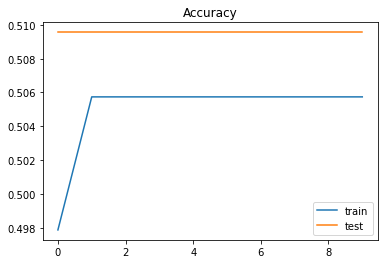

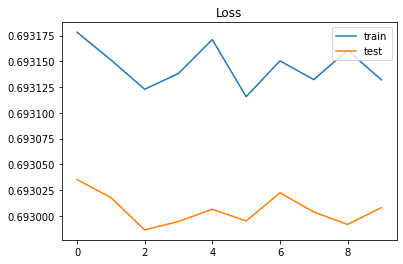

In [ ]:

batch_size = 32
epochs = 10
history = model.fit(
X_train.astype(np.float32), y_train.astype(np.float32),
initial_epoch=len(loss),
epochs=epochs + len(loss),
validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
batch_size=batch_size,
verbose=1,
)
loss = loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']
accuracy = accuracy + history.history['accuracy']
val_accuracy = val_accuracy + history.history['val_accuracy']
print('Lowest training loss = {:9.6f}, in epoch {} '.format(np.amin(loss),np.argmin(loss)+1))
print('Lowest validation loss = {:9.6f}, in epoch {} '.format(np.amin(val_loss),np.argmin(val_loss)+1))
print('Highest training accuracy = {:9.6f}, in epoch {} '.format(np.amax(accuracy),np.argmax(accuracy)+1))
print('Highest validation accuracy = {:9.6f}, in epoch {} '.format(np.amax(val_accuracy),np.argmax(val_accuracy)+1))
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'],label = 'train')
ax.plot(history.history['val_accuracy'],label = 'test')
ax.set_title('Accuracy')
ax.legend(loc='lower right')
fig, ax = plt.subplots()
ax.plot(history.history['loss'],label = 'train')
ax.plot(history.history['val_loss'],label = 'test')
ax.set_title('Loss')
ax.legend(loc='upper right')